In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from tensorflow.keras import initializers
import os
# set seed to reproduce similar results
np.random.seed(0)

In [2]:
from google.colab import drive   # 코랩 드라이브와 연동
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Data_path= "/content/drive/MyDrive/gachon4-2/deeplearning/week4"

In [6]:
names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', "NaN"]

data = pd.read_csv(os.path.join(Data_path,'WISDM_ar_v1.1_raw.txt'), header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["Z"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["Z"] = df["Z"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()

<ipython-input-6-cbbb26fe5866>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


,user-id,activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [7]:
np.unique(df.activity.values)

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [8]:
s_df=df[df.activity=="Sitting"].iloc[:4500]
r_df=df[df.activity=="Jogging"].iloc[:4500]

print(s_df.shape)
print(r_df.shape)

(4500, 6)
(4500, 6)


In [9]:
x_df= pd.concat([s_df,r_df])
print(x_df.shape)

(9000, 6)


In [10]:
from sklearn.preprocessing import StandardScaler
x_df = x_df.drop(['user-id'], axis=1)
x_df = x_df.drop(['timestamp'], axis=1)

x_df['X'] = StandardScaler().fit_transform(x_df['X'].values.reshape(-1, 1))
x_df['Y'] = StandardScaler().fit_transform(x_df['Y'].values.reshape(-1, 1))
x_df['Z'] = StandardScaler().fit_transform(x_df['Z'].values.reshape(-1, 1))

print(x_df.shape)

(9000, 4)


In [11]:
x_df.activity[x_df.activity == "Sitting"]=0
x_df.activity[x_df.activity == "Jogging"]=1

print(np.unique(x_df.activity))

[0 1]


<ipython-input-11-29749af48ecd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df.activity[x_df.activity == "Sitting"]=0
<ipython-input-11-29749af48ecd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_df.activity[x_df.activity == "Jogging"]=1


In [12]:
x_df

,activity,X,Y,Z
221333,0,0.353771,0.468699,-0.393346
221334,0,0.368867,0.451497,-0.512760
221335,0,0.521716,0.366808,-0.454584
221336,0,0.550021,0.431648,-0.417841
221337,0,0.412269,0.426355,-0.393346
...,...,...,...,...
13015,1,0.888650,0.361942,0.252714
13016,1,-0.954171,1.774960,-1.014910
13017,1,-0.332187,-1.472819,-1.633413
13018,1,1.199642,1.472171,-0.711783


In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test = train_test_split(x_df, test_size=0.2, random_state=0)
X_train = X_train[X_train.activity == 0]
X_train = X_train.drop(['activity'], axis=1)

y_test = X_test['activity']
X_test = X_test.drop(['activity'], axis=1)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape)
print(X_test.shape, " ", y_test.shape)

(3607, 3)
(1800, 3)   (1800,)


In [15]:
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

-1.2426446159748903 1.2692632707707026
-3.8196060955732842 3.1529798662238324


In [31]:
# Defining the Generator network

def get_generator(optimizer):

    generator = Sequential()
    generator.add(Dense(64, input_dim=3, kernel_initializer=initializers.glorot_normal(seed=42)))
    generator.add(Activation('tanh'))

    generator.add(Dense(128))
    generator.add(Activation('tanh'))

    generator.add(Dense(256))
    generator.add(Activation('tanh'))

    generator.add(Dense(256))
    generator.add(Activation('tanh'))

    generator.add(Dense(512))
    generator.add(Activation('tanh'))

    generator.add(Dense(3, activation='tanh'))

    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return generator

In [32]:
##### Defining the Discriminator network

def get_discriminator(optimizer):

    discriminator = Sequential()

    discriminator.add(Dense(256, input_dim=3, kernel_initializer=initializers.glorot_normal(seed=42)))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(128))
    discriminator.add(Activation('relu'))
    discriminator.add(Dropout(0.2))

    discriminator.add(Dense(1))
    discriminator.add(Activation('sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    return discriminator

In [33]:
def get_gan_network(discriminator, generator, optimizer,input_dim=X_train.shape[1]):

    discriminator.trainable = False
    gan_input = Input(shape=(input_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))


    return gan


In [68]:
from tqdm import tqdm
#Training the GAN

#learning_rate = 0.00001
learning_rate = 0.0001
batch_size = 512
epochs = 100
adam = Adam(learning_rate = learning_rate, beta_1 = 0.5)

#Calculating the number of batches based on the batch size
batch_count = X_train.shape[0] // batch_size
# pbar = tqdm(total= epochs * batch_count)
gan_loss = []
discriminator_loss = []

#Inititalizing the network
generator = get_generator(adam)
discriminator = get_discriminator(adam)
gan = get_gan_network(discriminator, generator, adam)


for epoch in tqdm(range(epochs)):
    for index in range(batch_count):
        # Creating a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batch_size,3])

        # Generate fake samples
        generated_images = generator.predict_on_batch(noise)

        #Obtain a batch of normal network packets
        image_batch = X_train[index * batch_size: (index + 1) * batch_size]

        X = np.vstack((generated_images,image_batch))
        y_dis = np.ones(2*batch_size)
        y_dis[:batch_size] = 0

        # Train discriminator
        discriminator.trainable = True
        d_loss= discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.uniform(0, 1, size=[batch_size, 3])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, y_gen)

        #Record the losses
        discriminator_loss.append(d_loss)
        gan_loss.append(g_loss)

    print("Epoch %d Batch %d/%d [D loss: %f] [G loss:%f]" % (epoch,index,batch_count, d_loss, g_loss))

  1%|          | 1/100 [00:04<07:18,  4.43s/it]

Epoch 0 Batch 6/7 [D loss: 0.683800] [G loss:0.610260]


  2%|▏         | 2/100 [00:04<03:26,  2.10s/it]

Epoch 1 Batch 6/7 [D loss: 0.636067] [G loss:0.590504]


  3%|▎         | 3/100 [00:05<02:13,  1.38s/it]

Epoch 2 Batch 6/7 [D loss: 0.519451] [G loss:0.525415]


  4%|▍         | 4/100 [00:05<01:38,  1.02s/it]

Epoch 3 Batch 6/7 [D loss: 0.434833] [G loss:0.608510]


  5%|▌         | 5/100 [00:06<01:18,  1.21it/s]

Epoch 4 Batch 6/7 [D loss: 0.369756] [G loss:0.935988]


  6%|▌         | 6/100 [00:06<01:06,  1.42it/s]

Epoch 5 Batch 6/7 [D loss: 0.303219] [G loss:1.032701]


  7%|▋         | 7/100 [00:07<00:58,  1.58it/s]

Epoch 6 Batch 6/7 [D loss: 0.322626] [G loss:1.047327]


  8%|▊         | 8/100 [00:07<00:54,  1.68it/s]

Epoch 7 Batch 6/7 [D loss: 0.271553] [G loss:1.185889]


  9%|▉         | 9/100 [00:08<00:51,  1.77it/s]

Epoch 8 Batch 6/7 [D loss: 0.195193] [G loss:1.640370]


 10%|█         | 10/100 [00:08<00:47,  1.88it/s]

Epoch 9 Batch 6/7 [D loss: 0.358532] [G loss:2.129577]


 11%|█         | 11/100 [00:09<00:52,  1.69it/s]

Epoch 10 Batch 6/7 [D loss: 0.177273] [G loss:2.310802]


 12%|█▏        | 12/100 [00:10<00:56,  1.55it/s]

Epoch 11 Batch 6/7 [D loss: 0.132200] [G loss:2.157670]


 13%|█▎        | 13/100 [00:12<01:26,  1.01it/s]

Epoch 12 Batch 6/7 [D loss: 0.352057] [G loss:2.228661]


 14%|█▍        | 14/100 [00:12<01:19,  1.08it/s]

Epoch 13 Batch 6/7 [D loss: 0.131124] [G loss:1.679203]


 15%|█▌        | 15/100 [00:13<01:14,  1.14it/s]

Epoch 14 Batch 6/7 [D loss: 0.123228] [G loss:2.621145]


 16%|█▌        | 16/100 [00:14<01:11,  1.17it/s]

Epoch 15 Batch 6/7 [D loss: 0.092980] [G loss:3.668854]


 17%|█▋        | 17/100 [00:15<01:09,  1.20it/s]

Epoch 16 Batch 6/7 [D loss: 0.073888] [G loss:3.241147]


 18%|█▊        | 18/100 [00:15<01:02,  1.32it/s]

Epoch 17 Batch 6/7 [D loss: 0.110741] [G loss:2.002615]


 19%|█▉        | 19/100 [00:16<00:55,  1.46it/s]

Epoch 18 Batch 6/7 [D loss: 0.063470] [G loss:3.387524]


 20%|██        | 20/100 [00:16<00:49,  1.61it/s]

Epoch 19 Batch 6/7 [D loss: 0.071573] [G loss:2.938251]


 21%|██        | 21/100 [00:17<00:45,  1.73it/s]

Epoch 20 Batch 6/7 [D loss: 0.052187] [G loss:1.467370]


 22%|██▏       | 22/100 [00:17<00:42,  1.84it/s]

Epoch 21 Batch 6/7 [D loss: 0.069695] [G loss:2.817488]


 23%|██▎       | 23/100 [00:18<00:41,  1.84it/s]

Epoch 22 Batch 6/7 [D loss: 0.070410] [G loss:4.173494]


 24%|██▍       | 24/100 [00:18<00:40,  1.89it/s]

Epoch 23 Batch 6/7 [D loss: 0.094493] [G loss:3.705245]


 25%|██▌       | 25/100 [00:19<00:39,  1.92it/s]

Epoch 24 Batch 6/7 [D loss: 0.034013] [G loss:3.159082]


 26%|██▌       | 26/100 [00:19<00:37,  1.98it/s]

Epoch 25 Batch 6/7 [D loss: 0.051815] [G loss:4.257371]


 27%|██▋       | 27/100 [00:20<00:36,  2.02it/s]

Epoch 26 Batch 6/7 [D loss: 0.031530] [G loss:4.062432]


 28%|██▊       | 28/100 [00:20<00:35,  2.05it/s]

Epoch 27 Batch 6/7 [D loss: 0.027067] [G loss:4.288210]


 29%|██▉       | 29/100 [00:21<00:33,  2.09it/s]

Epoch 28 Batch 6/7 [D loss: 0.024896] [G loss:4.496482]


 30%|███       | 30/100 [00:21<00:33,  2.10it/s]

Epoch 29 Batch 6/7 [D loss: 0.064030] [G loss:4.926785]


 31%|███       | 31/100 [00:22<00:33,  2.08it/s]

Epoch 30 Batch 6/7 [D loss: 0.016830] [G loss:4.716013]


 32%|███▏      | 32/100 [00:22<00:33,  2.04it/s]

Epoch 31 Batch 6/7 [D loss: 0.015460] [G loss:4.612758]


 33%|███▎      | 33/100 [00:23<00:32,  2.08it/s]

Epoch 32 Batch 6/7 [D loss: 0.021976] [G loss:5.128043]


 34%|███▍      | 34/100 [00:23<00:32,  2.05it/s]

Epoch 33 Batch 6/7 [D loss: 0.011268] [G loss:5.032249]


 35%|███▌      | 35/100 [00:24<00:30,  2.10it/s]

Epoch 34 Batch 6/7 [D loss: 0.041302] [G loss:7.373990]


 36%|███▌      | 36/100 [00:24<00:30,  2.12it/s]

Epoch 35 Batch 6/7 [D loss: 0.121351] [G loss:2.000982]


 37%|███▋      | 37/100 [00:24<00:30,  2.08it/s]

Epoch 36 Batch 6/7 [D loss: 0.037661] [G loss:2.905555]


 38%|███▊      | 38/100 [00:25<00:30,  2.06it/s]

Epoch 37 Batch 6/7 [D loss: 0.031711] [G loss:3.619738]


 39%|███▉      | 39/100 [00:26<00:34,  1.75it/s]

Epoch 38 Batch 6/7 [D loss: 0.030808] [G loss:3.974314]


 40%|████      | 40/100 [00:27<00:37,  1.58it/s]

Epoch 39 Batch 6/7 [D loss: 0.021944] [G loss:3.930501]


 41%|████      | 41/100 [00:27<00:39,  1.48it/s]

Epoch 40 Batch 6/7 [D loss: 0.022547] [G loss:4.049607]


 42%|████▏     | 42/100 [00:28<00:40,  1.42it/s]

Epoch 41 Batch 6/7 [D loss: 0.021236] [G loss:4.751616]


 43%|████▎     | 43/100 [00:29<00:41,  1.39it/s]

Epoch 42 Batch 6/7 [D loss: 0.018001] [G loss:4.500792]


 44%|████▍     | 44/100 [00:30<00:41,  1.36it/s]

Epoch 43 Batch 6/7 [D loss: 0.016011] [G loss:5.002994]


 45%|████▌     | 45/100 [00:30<00:40,  1.36it/s]

Epoch 44 Batch 6/7 [D loss: 0.010443] [G loss:4.501088]


 46%|████▌     | 46/100 [00:31<00:39,  1.35it/s]

Epoch 45 Batch 6/7 [D loss: 0.009820] [G loss:4.930331]


 47%|████▋     | 47/100 [00:32<00:37,  1.43it/s]

Epoch 46 Batch 6/7 [D loss: 0.011175] [G loss:5.215478]


 48%|████▊     | 48/100 [00:32<00:33,  1.57it/s]

Epoch 47 Batch 6/7 [D loss: 0.011200] [G loss:5.595666]


 49%|████▉     | 49/100 [00:33<00:29,  1.71it/s]

Epoch 48 Batch 6/7 [D loss: 0.010434] [G loss:5.786391]


 50%|█████     | 50/100 [00:33<00:27,  1.83it/s]

Epoch 49 Batch 6/7 [D loss: 0.008035] [G loss:5.264701]


 51%|█████     | 51/100 [00:34<00:27,  1.78it/s]

Epoch 50 Batch 6/7 [D loss: 0.010091] [G loss:5.919284]


 52%|█████▏    | 52/100 [00:34<00:25,  1.85it/s]

Epoch 51 Batch 6/7 [D loss: 0.017949] [G loss:7.589694]


 53%|█████▎    | 53/100 [00:35<00:24,  1.92it/s]

Epoch 52 Batch 6/7 [D loss: 0.004560] [G loss:5.238792]


 54%|█████▍    | 54/100 [00:35<00:23,  1.99it/s]

Epoch 53 Batch 6/7 [D loss: 0.004697] [G loss:6.096520]


 55%|█████▌    | 55/100 [00:36<00:22,  2.03it/s]

Epoch 54 Batch 6/7 [D loss: 0.008162] [G loss:6.078789]


 56%|█████▌    | 56/100 [00:36<00:21,  2.05it/s]

Epoch 55 Batch 6/7 [D loss: 0.007483] [G loss:5.847252]


 57%|█████▋    | 57/100 [00:37<00:20,  2.06it/s]

Epoch 56 Batch 6/7 [D loss: 0.002286] [G loss:5.700999]


 58%|█████▊    | 58/100 [00:37<00:20,  2.08it/s]

Epoch 57 Batch 6/7 [D loss: 0.003073] [G loss:5.963479]


 59%|█████▉    | 59/100 [00:38<00:20,  2.00it/s]

Epoch 58 Batch 6/7 [D loss: 0.017245] [G loss:8.782141]


 60%|██████    | 60/100 [00:38<00:19,  2.04it/s]

Epoch 59 Batch 6/7 [D loss: 0.007460] [G loss:6.341363]


 61%|██████    | 61/100 [00:39<00:18,  2.08it/s]

Epoch 60 Batch 6/7 [D loss: 0.003336] [G loss:6.715022]


 62%|██████▏   | 62/100 [00:39<00:18,  2.10it/s]

Epoch 61 Batch 6/7 [D loss: 0.003629] [G loss:5.688117]


 63%|██████▎   | 63/100 [00:39<00:17,  2.11it/s]

Epoch 62 Batch 6/7 [D loss: 0.006425] [G loss:6.278763]


 64%|██████▍   | 64/100 [00:40<00:17,  2.03it/s]

Epoch 63 Batch 6/7 [D loss: 0.004631] [G loss:5.764740]


 65%|██████▌   | 65/100 [00:41<00:18,  1.93it/s]

Epoch 64 Batch 6/7 [D loss: 0.003246] [G loss:6.628582]


 66%|██████▌   | 66/100 [00:41<00:17,  1.96it/s]

Epoch 65 Batch 6/7 [D loss: 0.005419] [G loss:7.677637]


 67%|██████▋   | 67/100 [00:42<00:17,  1.87it/s]

Epoch 66 Batch 6/7 [D loss: 0.001065] [G loss:6.987778]


 68%|██████▊   | 68/100 [00:42<00:19,  1.60it/s]

Epoch 67 Batch 6/7 [D loss: 0.003923] [G loss:7.026232]


 69%|██████▉   | 69/100 [00:43<00:20,  1.52it/s]

Epoch 68 Batch 6/7 [D loss: 0.002697] [G loss:6.888871]


 70%|███████   | 70/100 [00:44<00:20,  1.44it/s]

Epoch 69 Batch 6/7 [D loss: 0.005483] [G loss:5.934722]


 71%|███████   | 71/100 [00:45<00:20,  1.41it/s]

Epoch 70 Batch 6/7 [D loss: 0.001971] [G loss:6.964253]


 72%|███████▏  | 72/100 [00:45<00:20,  1.39it/s]

Epoch 71 Batch 6/7 [D loss: 0.002357] [G loss:6.933719]


 73%|███████▎  | 73/100 [00:46<00:19,  1.38it/s]

Epoch 72 Batch 6/7 [D loss: 0.004447] [G loss:7.570955]


 74%|███████▍  | 74/100 [00:47<00:19,  1.36it/s]

Epoch 73 Batch 6/7 [D loss: 0.001746] [G loss:7.106040]


 75%|███████▌  | 75/100 [00:48<00:18,  1.36it/s]

Epoch 74 Batch 6/7 [D loss: 0.001912] [G loss:6.916827]


 76%|███████▌  | 76/100 [00:48<00:16,  1.50it/s]

Epoch 75 Batch 6/7 [D loss: 0.001633] [G loss:7.013956]


 77%|███████▋  | 77/100 [00:49<00:14,  1.54it/s]

Epoch 76 Batch 6/7 [D loss: 0.001308] [G loss:7.010232]


 78%|███████▊  | 78/100 [00:49<00:13,  1.69it/s]

Epoch 77 Batch 6/7 [D loss: 0.001117] [G loss:7.165530]


 79%|███████▉  | 79/100 [00:50<00:11,  1.76it/s]

Epoch 78 Batch 6/7 [D loss: 0.000911] [G loss:7.592378]


 80%|████████  | 80/100 [00:50<00:10,  1.82it/s]

Epoch 79 Batch 6/7 [D loss: 0.001413] [G loss:8.289040]


 81%|████████  | 81/100 [00:51<00:10,  1.90it/s]

Epoch 80 Batch 6/7 [D loss: 0.001835] [G loss:7.754070]


 82%|████████▏ | 82/100 [00:51<00:09,  1.95it/s]

Epoch 81 Batch 6/7 [D loss: 0.000997] [G loss:7.997192]


 83%|████████▎ | 83/100 [00:52<00:08,  1.92it/s]

Epoch 82 Batch 6/7 [D loss: 0.002592] [G loss:8.261415]


 84%|████████▍ | 84/100 [00:52<00:08,  1.90it/s]

Epoch 83 Batch 6/7 [D loss: 0.001987] [G loss:8.010514]


 85%|████████▌ | 85/100 [00:53<00:07,  1.96it/s]

Epoch 84 Batch 6/7 [D loss: 0.000624] [G loss:7.923946]


 86%|████████▌ | 86/100 [00:53<00:07,  1.98it/s]

Epoch 85 Batch 6/7 [D loss: 0.000487] [G loss:7.953764]


 87%|████████▋ | 87/100 [00:54<00:06,  2.03it/s]

Epoch 86 Batch 6/7 [D loss: 0.002204] [G loss:7.543680]


 88%|████████▊ | 88/100 [00:54<00:05,  2.04it/s]

Epoch 87 Batch 6/7 [D loss: 0.000793] [G loss:7.738665]


 89%|████████▉ | 89/100 [00:55<00:05,  2.06it/s]

Epoch 88 Batch 6/7 [D loss: 0.000572] [G loss:7.875233]


 90%|█████████ | 90/100 [00:55<00:04,  2.09it/s]

Epoch 89 Batch 6/7 [D loss: 0.000606] [G loss:8.159133]


 91%|█████████ | 91/100 [00:56<00:04,  2.05it/s]

Epoch 90 Batch 6/7 [D loss: 0.000535] [G loss:7.969333]


 92%|█████████▏| 92/100 [00:56<00:03,  2.07it/s]

Epoch 91 Batch 6/7 [D loss: 0.000372] [G loss:8.285252]


 93%|█████████▎| 93/100 [00:57<00:03,  2.10it/s]

Epoch 92 Batch 6/7 [D loss: 0.000763] [G loss:8.343362]


 94%|█████████▍| 94/100 [00:57<00:02,  2.02it/s]

Epoch 93 Batch 6/7 [D loss: 0.000954] [G loss:8.534436]


 95%|█████████▌| 95/100 [00:58<00:02,  2.05it/s]

Epoch 94 Batch 6/7 [D loss: 0.002265] [G loss:8.190917]


 96%|█████████▌| 96/100 [00:58<00:02,  1.90it/s]

Epoch 95 Batch 6/7 [D loss: 0.001014] [G loss:8.649905]


 97%|█████████▋| 97/100 [00:59<00:01,  1.68it/s]

Epoch 96 Batch 6/7 [D loss: 0.000327] [G loss:8.506433]


 98%|█████████▊| 98/100 [01:00<00:01,  1.57it/s]

Epoch 97 Batch 6/7 [D loss: 0.000519] [G loss:8.421563]


 99%|█████████▉| 99/100 [01:00<00:00,  1.48it/s]

Epoch 98 Batch 6/7 [D loss: 0.000354] [G loss:8.520796]


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

Epoch 99 Batch 6/7 [D loss: 0.000451] [G loss:8.383997]


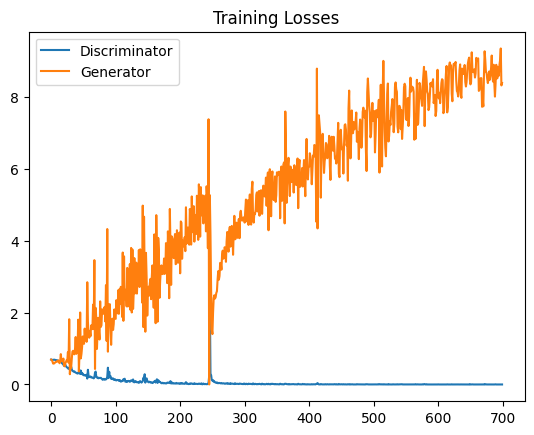

In [69]:
fig, ax = plt.subplots()
plt.plot(discriminator_loss, label='Discriminator')
plt.plot(gan_loss, label='Generator')
plt.title("Training Losses")
plt.legend()

In [70]:
# Predictions on the test set

nr_batches_test = np.ceil(X_test.shape[0] // batch_size).astype(np.int32)

results =[]

for t in range(nr_batches_test +1):
        ran_from = t * batch_size
        ran_to = (t + 1) * batch_size
        image_batch = X_test[ran_from:ran_to]
        tmp_rslt = discriminator.predict(x=image_batch,batch_size=128,verbose=0)
        results = np.append(results, tmp_rslt)

In [75]:
results.mean()

0.5051358763433702

In [71]:
y2 = y_test.to_numpy()

In [79]:
pd.options.display.float_format = '{:20,.7f}'.format
results_df = pd.concat([pd.DataFrame(results),pd.DataFrame(y2)], axis=1)
results_df.columns = ['results','y_test']
print ('Mean score for Jogging data :', results_df.loc[results_df['results'] > 0.5, 'results'].mean() )
print ('Mean score for Sitting data :', results_df.loc[results_df['results'] < 0.5, 'results'].mean())

Mean score for Jogging data : 0.9995017835278192
Mean score for Sitting data : 0.0007827791147911829


In [82]:
#Obtaining the lowest 1% score
# per = np.percentile(results,1)
per = 0.5
y_pred = results.copy()
y_pred = np.array(y_pred)

print(per)

0.5


In [87]:
#Thresholding based on the score
inds = (y_pred > per)
inds_comp = (y_pred <= per)
y_pred[inds] = 0
y_pred[inds_comp] = 1

In [88]:
y_pred

array([0., 0., 1., ..., 1., 1., 1.])

In [89]:
np.array(y_test).astype(int)

array([0, 0, 1, ..., 1, 1, 1])

In [90]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
precision, recall, f1,_ = precision_recall_fscore_support(np.array(y_test).astype(int),y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(np.array(y_test).astype(int), y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.9911111111111112
Precision : 1.0
Recall : 0.9823594266813671
F1 : 0.9911012235817575


Confusion Matrix :


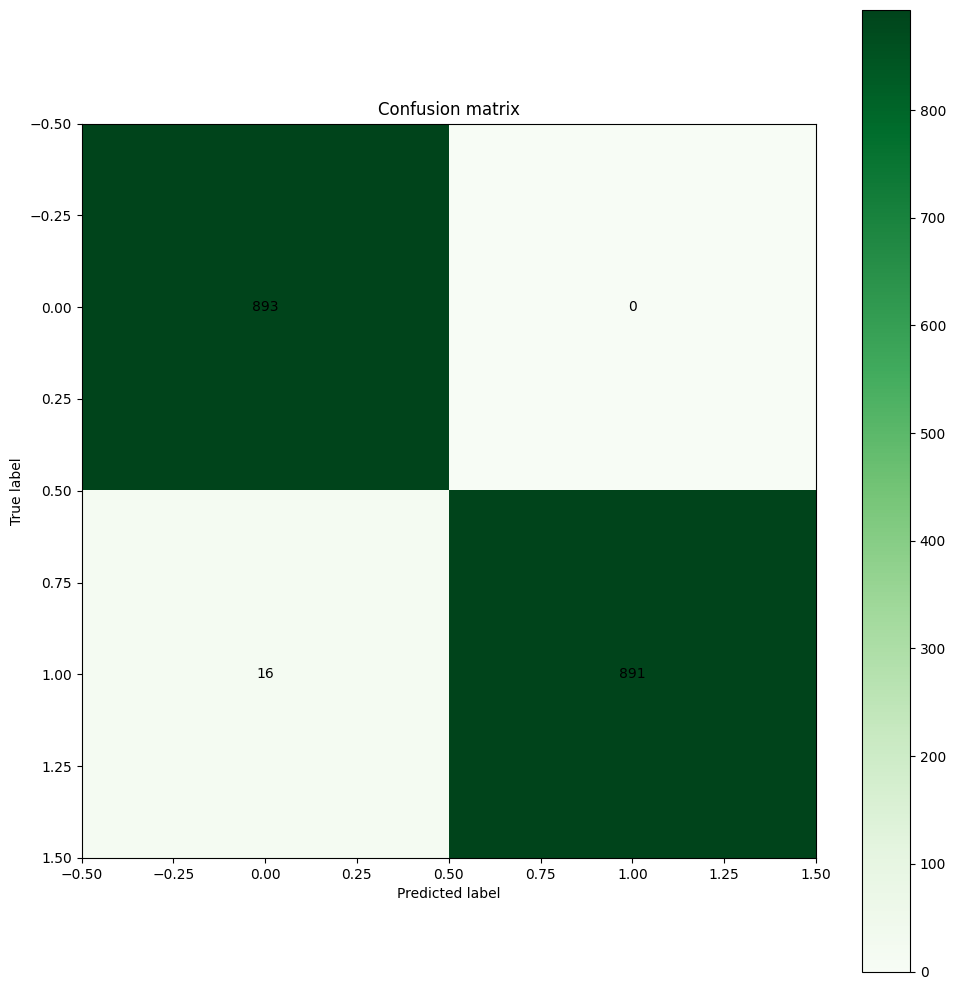

In [91]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(y_test).astype(int), y_pred)

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(10,10),)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(cm)

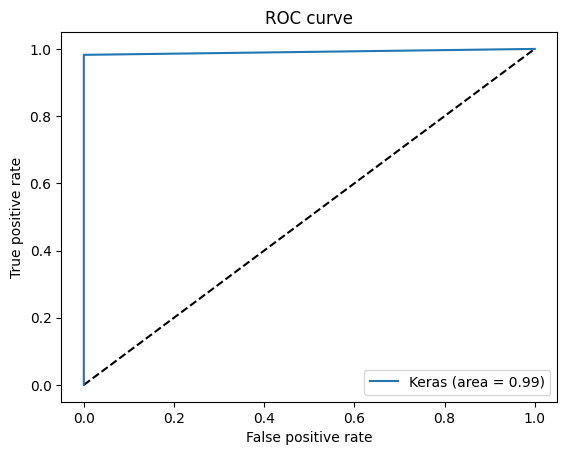

In [92]:
from sklearn.metrics import roc_curve, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(np.array(y_test).astype(int), y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.2f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()